In [71]:
import numpy as np
import pandas as pd

# Room draw optimization data generation
## 1. Model for multiple preferences with individual parties
Consistent with the output in multi_preferences model in `multi_preferences.mod`

In [72]:
# number parameters
n_rooms = 200
n_people = 200
n_preferences = 5

ROOMS = list(range(1, n_rooms + 1))
PEOPLE = list(range(1, n_people + 1))
PREFERENCES = list(range(1, n_preferences + 1))

# preference and weight parameters
weights = {(p, pr): n_preferences - pr  + 1 for p in PEOPLE for pr in PREFERENCES}



preferences = np.random.randint(low=1,high=n_rooms,size=(n_people, n_preferences))
preferences_lower = preferences
preferences_upper = np.minimum(preferences + np.random.randint(0, 5, (n_rooms, n_preferences)), n_rooms*np.ones((n_rooms, n_preferences))).astype(np.int64)


In [73]:
# save these to text to be interpreted by the models
c = ['PEOPLE', 'PREFERENCES', 'preference_lower', 'preference_upper', 'weights']
table = np.zeros((n_people*n_preferences, 5), dtype=np.int32)
for i in range(n_people ):
    for j in range(n_preferences):
        table[i*n_preferences + j][0] = i + 1
        table[i*n_preferences + j][1] = j + 1
        table[i*n_preferences + j][2] = preferences_lower[i,j]
        table[i*n_preferences + j][3] = preferences_upper[i,j]
        table[i*n_preferences + j][4] = n_preferences - j
table = pd.DataFrame(table, columns=c).set_index(['PEOPLE', 'PREFERENCES'])
table.to_csv('preferences.csv', index=False)

## Simulate Greedy Room Draw
Assume that all agents act independently, selecting the first available room of highest choice

In [91]:
assignment = np.zeros(n_people, dtype=np.int32)
weight = np.zeros(n_people, dtype=np.int32)
for person in range(n_people):
    assigned = False
    for pref in range(n_preferences):
        for i in range(preferences_lower[person, pref]-1, preferences_upper[person, pref]):
            if not assignment[i]:
                assigned = True
                assignment[i] = person
                weight[i] = n_preferences - pref
                break
        if assigned:
            break
    if not assigned:
        for i in range(n_rooms):
            if not assignment[i]:
                assignment[i] = person
                break
greedy_assignment = pd.DataFrame(assignment, columns=['room number'])
greedy_satisfied = pd.DataFrame(weight, columns=['satisfied'])
greedy_assignment['groups'] = PEOPLE
greedy_satisfied['groups'] = PEOPLE
greedy_assignment.set_index('groups', inplace=True)
greedy_satisfied.set_index('groups', inplace=True)

# transform to get satisfied preference numbers
greedy_satisfied['satisfied'] = greedy_satisfied['satisfied'].apply(lambda x: -x + 6 if x else 0)
greedy_utility = sum(weight)

# AMPL Python API Tests

In [75]:
from amplpy import AMPL, Environment

In [76]:
# init ampl
ampl = AMPL(Environment('/usr/bin'))
model = 'range_preferences.mod'

In [77]:
# read in model
ampl.eval('option solver gurobi;')
ampl.read(filename=model)

In [78]:
# set data
ampl.get_parameter("n_people").set(n_people)
ampl.get_parameter("n_rooms").set(n_rooms)
ampl.get_parameter("n_preferences").set(n_preferences)
ampl.set_data(data=table, set_name='LINKS')

In [79]:
ampl.solve()

Gurobi 9.5.1: optimal solution; objective 1025
3532 simplex iterations
1 branch-and-cut nodes


In [89]:
optim_assignments = ampl.get_variable('room_number').get_values().to_pandas()
# clean up the dataframe
optim_assignments = optim_assignments.rename(columns={'room_number.val': 'room number'}).set_axis(np.arange(1, 201, 1, dtype=int)).rename_axis('Groups').astype(int)
optim_utility = int(ampl.get_objective('Objective').value())


In [81]:
# process output
optim_satisfied = ampl.get_variable('satisfied').get_values().to_pandas()
optim_satisfied['group'] = [int(a[0]) for a in optim_satisfied.index]
optim_satisfied['preference'] = [int(a[1]) for a in optim_satisfied.index]
optim_satisfied.set_index(['group', 'preference'],inplace=True)
optim_satisfied.rename(columns={'satisfied.val':'satisfied'}, inplace=True)
optim_satisfied = optim_satisfied.astype(bool)

def arg(x):
    for j in x.index:
        if x.loc[j]['satisfied']:
            return j[1]
    return 0


        
optim_satisfied = optim_satisfied.groupby('group').apply(arg).to_frame(name='satisfied')

# Comparison of Greedy and Optimized Assignments

In [82]:
import matplotlib.pyplot as plt

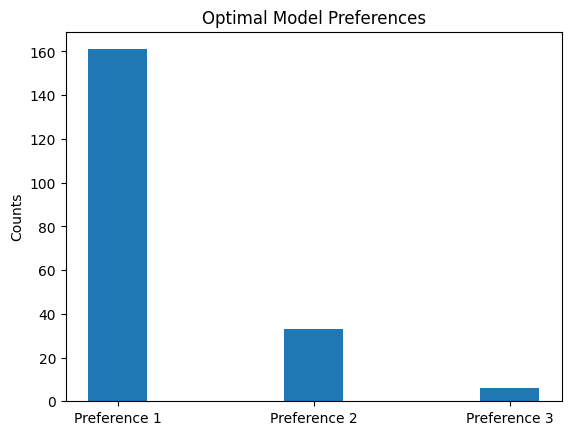

In [83]:
plt.bar(x=optim_satisfied.satisfied.value_counts().index, height=optim_satisfied.satisfied.value_counts().values, tick_label=[f'Preference {a}' for a in optim_satisfied.satisfied.value_counts().index], width=0.3)
plt.title('Optimal Model Preferences')
plt.ylabel('Counts')
plt.show()

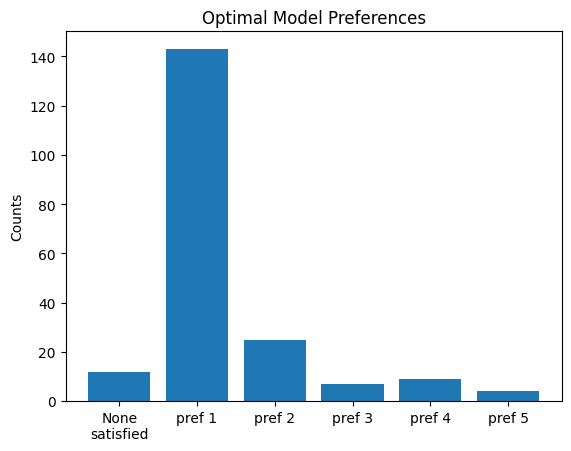

In [84]:
labels = []
for p in greedy_satisfied.satisfied.value_counts().index:
    if not p:
        labels += ['None\nsatisfied']
    else:
        labels += [f'pref {p}']

plt.bar(x=greedy_satisfied.satisfied.value_counts().index, height=greedy_satisfied.satisfied.value_counts().values, tick_label=labels)
plt.title('Optimal Model Preferences')
plt.ylabel('Counts')
plt.show()

In [110]:
print(f'''##### METRICS ######
Total utility greedy: {greedy_utility}
Total utility optimized: {optim_utility}

Percentage improvement in optimized model: {100*(optim_utility/greedy_utility - 1):.2f}%
Percentage improvement any preference satisfaction: {100*(sum((optim_satisfied > 0).satisfied)/sum((greedy_satisfied > 0).satisfied) - 1):.2f}%

Percentage improvement pref 1 satisfaction: {100*(sum((optim_satisfied == 1).satisfied)/sum((greedy_satisfied == 1).satisfied) - 1):.2f}%
Percentage improvement pref 2 satisfaction: {100*(sum((optim_satisfied == 2).satisfied)/sum((greedy_satisfied == 2).satisfied) - 1):.2f}%
Percentage improvement pref 3 satisfaction: {100*(sum((optim_satisfied == 3).satisfied)/sum((greedy_satisfied == 3).satisfied) - 1):.2f}%*


*Note: preference rank satisfactions are codependent. This means that a negative improvement for one preference doesn't imply an overall worse preference satisfaction performance''')

##### METRICS ######
Total utility greedy: 858
Total utility optimized: 1025

Percentage improvement in optimized model: 19.46%
Percentage improvement any preference satisfaction: 6.38%

Percentage improvement pref 1 satisfaction: 12.59%
Percentage improvement pref 2 satisfaction: 32.00%
Percentage improvement pref 3 satisfaction: -14.29%*


*Note: preference rank satisfactions are codependent. This means that a negative improvement for one preference doesn't imply an overall worse preference satisfaction performance
